# EMAIL SPAM DETECTION WITH MACHINE LEARNING

**Problem Statement:** 
               We’ve all been the recipient of spam emails before. Spam mail, or junk mail, is a type of email that is sent to a massive number of users at one time, frequently containing cryptic
messages, scams, or most dangerously, phishing content. Use Python to build an email spam detector. Then, use machine learning to train the spam detector to recognize and classify emails into spam and non-spam. 

**Objective:** To classify an email is spam or not by build a machine learning model.

**Download the dataset from here:**
          https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sms-spam-collection-dataset/spam.csv


# 1.Importing Libraries

In [2]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import nltk
from nltk.corpus import stopwords
from collections import Counter


#libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Loading the Data

In [3]:
df= pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='ISO-8859-1')

# 3. Exploratory Data Analysis

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


The dataset contains 5,572 entries and 5 columns. Here's a brief overview of the columns:

v1: Indicates whether the message is spam or ham (non-spam).
v2: Contains the text of the message.
Unnamed: 2, Unnamed: 3, Unnamed: 4: These columns have a significant number of missing values and might not be relevant for our analysis.
The v1 and v2 columns are crucial for our spam detection system, with v1 serving as the target variable and v2 as the feature from which we'll extract information for classification.

In [6]:
#Check column list present in df
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [7]:
#check descriptive statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
#Lets see null value count in df
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [9]:
df.isnull().mean()*100  #check the percentage of null value

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

As we can see there are huge number of missing entries in Unnamed:2,Unnamed:3,Unnamed:4 col i.e more than 99%.So we should have to remove these column.

In [10]:
df.drop(columns=df[['Unnamed: 2','Unnamed: 3','Unnamed: 4']],axis=1,inplace=True)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
df=df.drop_duplicates()
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [12]:
df.describe()

,v1,v2
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [13]:
df.shape


(5169, 2)

# 4.Data Preprocessing

In [14]:
#Rename columns names for easy to understand, we can also use df.rename
df.columns=['spam/ham','sms']

In [15]:
#Convert the text data into numerical form
df.loc[df['spam/ham'] == 'spam', 'spam/ham',] = 0
df.loc[df['spam/ham'] == 'ham', 'spam/ham',] = 1
df

/tmp/ipykernel_18/3347313260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['spam/ham'] == 'spam', 'spam/ham',] = 0
/tmp/ipykernel_18/3347313260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['spam/ham'] == 'ham', 'spam/ham',] = 1


,spam/ham,sms
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...
5568,1,Will Ì_ b going to esplanade fr home?
5569,1,"Pity, * was in mood for that. So...any other s..."
5570,1,The guy did some bitching but I acted like i'd...


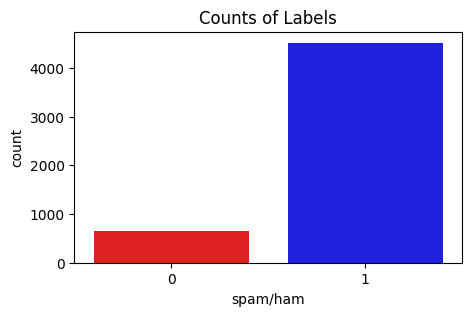

In [16]:
fig = plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='spam/ham', palette=["red", "blue"])
plt.title("Counts of Labels")
plt.show()

Here the spam sms frequency is shown red color and are less than 1000 in number wehreas the ham sms are shown blue in color and are more than 4000.

In [17]:
x=df.sms
y =df['spam/ham']

In [18]:
x

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: sms, Length: 5169, dtype: object

In [19]:
y

0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: spam/ham, Length: 5169, dtype: object

In [20]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=3)

In [21]:
print(x.shape)
print(xtrain.shape)
print(xtest.shape)

(5169,)
(4135,)
(1034,)


In [22]:
xtrain,xtest

(4443                       COME BACK TO TAMPA FFFFUUUUUUU
 982     Congrats! 2 mobile 3G Videophones R yours. cal...
 3822    Please protect yourself from e-threats. SIB ne...
 3924       As if i wasn't having enough trouble sleeping.
 4927    Just hopeing that wasnÛ÷t too pissed up to re...
                               ...                        
 806      sure, but make sure he knows we ain't smokin yet
 990                                          26th OF JULY
 1723    Hi Jon, Pete here, Ive bin 2 Spain recently & ...
 3519    No it will reach by 9 only. She telling she wi...
 1745    IåÕm cool ta luv but v.tired 2 cause i have be...
 Name: sms, Length: 4135, dtype: object,
 4994    Just looked it up and addie goes back Monday, ...
 4292    You best watch what you say cause I get drunk ...
 4128                 Me i'm not workin. Once i get job...
 4429          Yar lor... How u noe? U used dat route too?
 660     Under the sea, there lays a rock. In the rock,...
               

In [23]:
ytrain,ytest

(4443    1
 982     0
 3822    1
 3924    1
 4927    1
        ..
 806     1
 990     1
 1723    1
 3519    1
 1745    1
 Name: spam/ham, Length: 4135, dtype: object,
 4994    1
 4292    1
 4128    1
 4429    1
 660     1
        ..
 4003    1
 1107    1
 5413    1
 1413    0
 4998    1
 Name: spam/ham, Length: 1034, dtype: object)

In [24]:
feat_vect=TfidfVectorizer(min_df=1,stop_words='english',lowercase=True)
feat_vect

TfidfVectorizer(stop_words='english')

In [25]:
ytrain=ytrain.astype('int')
ytest=ytest.astype('int')

In [26]:
xtrain_vec =feat_vect.fit_transform(xtrain)

In [27]:
xtest_vec =feat_vect.transform(xtest)

In [28]:
print(xtrain)

4443                       COME BACK TO TAMPA FFFFUUUUUUU
982     Congrats! 2 mobile 3G Videophones R yours. cal...
3822    Please protect yourself from e-threats. SIB ne...
3924       As if i wasn't having enough trouble sleeping.
4927    Just hopeing that wasnÛ÷t too pissed up to re...
                              ...                        
806      sure, but make sure he knows we ain't smokin yet
990                                          26th OF JULY
1723    Hi Jon, Pete here, Ive bin 2 Spain recently & ...
3519    No it will reach by 9 only. She telling she wi...
1745    IåÕm cool ta luv but v.tired 2 cause i have be...
Name: sms, Length: 4135, dtype: object


In [29]:
xtrain_vec

<4135x7378 sparse matrix of type '<class 'numpy.float64'>'
	with 31488 stored elements in Compressed Sparse Row format>

In [30]:
print(xtrain_vec)

  (0, 2697)	0.7205755344386542
  (0, 6409)	0.5950532917415522
  (0, 1825)	0.35592482233751443
  (1, 5438)	0.27399320458839144
  (1, 4583)	0.27399320458839144
  (1, 4438)	0.22516921191243092
  (1, 5036)	0.27399320458839144
  (1, 2274)	0.27399320458839144
  (1, 2920)	0.23390504161994488
  (1, 3610)	0.27399320458839144
  (1, 4984)	0.19732502227978832
  (1, 4180)	0.23390504161994488
  (1, 7137)	0.24133495616477563
  (1, 6940)	0.27399320458839144
  (1, 203)	0.27399320458839144
  (1, 6941)	0.27399320458839144
  (1, 453)	0.25698446420786897
  (1, 4333)	0.15929709793058355
  (1, 1885)	0.22516921191243092
  (2, 953)	0.26160275768603725
  (2, 4856)	0.26160275768603725
  (2, 5786)	0.26160275768603725
  (2, 2459)	0.22436535516409714
  (2, 4960)	0.26160275768603725
  (2, 5976)	0.1902832473629628
  :	:
  (4132, 6862)	0.11085392369947865
  (4132, 5612)	0.14854309693836068
  (4132, 3865)	0.16898098428277844
  (4133, 6457)	0.6154177820886059
  (4133, 5320)	0.5530764956488926
  (4133, 2311)	0.4238274869

In [31]:
print(xtest_vec)

  (0, 6284)	0.43430701953285156
  (0, 4357)	0.4264504812056483
  (0, 3999)	0.4541039150126108
  (0, 3685)	0.21875536593912145
  (0, 3008)	0.3755569393427584
  (0, 796)	0.48415917776958733
  (1, 7050)	0.41978523395044104
  (1, 5656)	0.35499712111138654
  (1, 2369)	0.5617364019285492
  (1, 1608)	0.47304204171951914
  (1, 1254)	0.398046282326562
  (2, 7221)	0.7923997102028898
  (2, 3640)	0.6100022125126892
  (3, 7292)	0.4854329061592562
  (3, 6879)	0.504266116821645
  (3, 4574)	0.45819212318042857
  (3, 4009)	0.3321387620897908
  (3, 2080)	0.43567694225913534
  (4, 7218)	0.2292199492753507
  (4, 5689)	0.23694703770184997
  (4, 5540)	0.5218991333605264
  (4, 4823)	0.5112231722851113
  (4, 2508)	0.597985350067042
  (5, 3025)	0.5652583430208418
  (5, 1132)	0.8249139383264974
  :	:
  (1031, 5191)	0.3701308998039874
  (1031, 4565)	0.6439113578053595
  (1031, 4068)	0.3041309124908908
  (1031, 510)	0.42409124971092943
  (1032, 7339)	0.2632164916232764
  (1032, 7271)	0.269584829223756
  (1032, 69

### Using Logistic Regression

In [32]:
logi=LogisticRegression()
logi.fit(xtrain_vec,ytrain)

LogisticRegression()

In [33]:
logi.score(xtrain_vec,ytrain)

0.962273276904474

In [34]:
logi.score(xtest_vec,ytest)

0.960348162475822

In [35]:
pred_logi=logi.predict(xtest_vec)
pred_logi

array([1, 1, 1, ..., 1, 0, 1])

In [36]:
accuracy_score(ytest,pred_logi)
confusion_matrix(ytest,pred_logi)

array([[ 99,  41],
       [  0, 894]])

In [37]:
print(classification_report(ytest,pred_logi))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       140
           1       0.96      1.00      0.98       894

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034



Logistic regression is a good machine learning model for classifying a spam or a ham email